In [88]:
import tensorflow as tf
from tensorflow import keras
from random import shuffle
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os

In [89]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
NUM_CLASSES = 1

In [90]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

In [91]:
# Added layer to base model
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

In [92]:
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loos_fn = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loos_fn, metrics=['accuracy'])

In [93]:
x_train = []
y_train = []
x_test = []
y_test = []

In [94]:
dataTr = []

for filename in glob.glob(os.path.join('catdogs/train/cats/','*.jpg')):
    dataTr.append([1, cv.resize(cv.imread(filename), dsize=(224, 224), interpolation=cv.INTER_CUBIC)])
for filename in glob.glob(os.path.join('catdogs/train/dogs/','*.jpg')):
    dataTr.append([0, cv.resize(cv.imread(filename), dsize=(224, 224), interpolation=cv.INTER_CUBIC)])

print('Images loaded', len(dataTr))

Images loaded 4000


In [95]:
# Shuffle data
for i, j in dataTr:
    x_train.append(j)
    y_train.append(i)
x_train = np.array(x_train)/255 # Normalize
y_train = np.array(y_train)

In [96]:
for filename in glob.glob(os.path.join('catdogs/test/cats/','*.jpg')):
    x_test.append(cv.resize(cv.imread(filename), dsize=(224, 224), interpolation=cv.INTER_CUBIC))
    y_test.append(1)
for filename in glob.glob(os.path.join('catdogs/test/dogs/','*.jpg')):
    x_test.append(cv.resize(cv.imread(filename), dsize=(224, 224), interpolation=cv.INTER_CUBIC))
    y_test.append(0)

print('Images loaded', len(x_test))
print('Labels loaded', len(y_test))

Images loaded 1000
Labels loaded 1000


In [97]:
x_test = np.array(x_test)/255 # Normalize
y_test = np.array(y_test)

In [98]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 3,
    verbose = 0,
    restore_best_weights = True
)

In [99]:
nav = model.fit(
    x_train, y_train,
    batch_size = BATCH_SIZE,
    epochs = NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = (x_test, y_test), 
    verbose = 2
)

Epoch 1/10
63/63 - 126s - loss: 1.2835 - accuracy: 0.9532 - val_loss: 0.1099 - val_accuracy: 0.9820 - 126s/epoch - 2s/step
Epoch 2/10
63/63 - 114s - loss: 0.0608 - accuracy: 0.9870 - val_loss: 0.1042 - val_accuracy: 0.9640 - 114s/epoch - 2s/step
Epoch 3/10
63/63 - 111s - loss: 0.0410 - accuracy: 0.9885 - val_loss: 0.0887 - val_accuracy: 0.9830 - 111s/epoch - 2s/step
Epoch 4/10
63/63 - 111s - loss: 0.0559 - accuracy: 0.9852 - val_loss: 0.0450 - val_accuracy: 0.9820 - 111s/epoch - 2s/step
Epoch 5/10
63/63 - 111s - loss: 0.0139 - accuracy: 0.9948 - val_loss: 0.0508 - val_accuracy: 0.9810 - 111s/epoch - 2s/step
Epoch 6/10
63/63 - 111s - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.0645 - val_accuracy: 0.9830 - 111s/epoch - 2s/step
Epoch 7/10
63/63 - 111s - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.0755 - val_accuracy: 0.9830 - 111s/epoch - 2s/step


In [108]:
history = nav
print(history.history)

{'loss': [1.283522367477417, 0.0607844702899456, 0.041000209748744965, 0.05585458502173424, 0.013867187313735485, 0.006582736968994141, 0.006896422244608402], 'accuracy': [0.953249990940094, 0.9869999885559082, 0.9884999990463257, 0.9852499961853027, 0.9947500228881836, 0.9977499842643738, 0.9972500205039978], 'val_loss': [0.1099167913198471, 0.10415884852409363, 0.08871954679489136, 0.04503209516406059, 0.0507543720304966, 0.06446869671344757, 0.0755271464586258], 'val_accuracy': [0.9819999933242798, 0.9639999866485596, 0.9829999804496765, 0.9819999933242798, 0.9810000061988831, 0.9829999804496765, 0.9829999804496765]}


In [101]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss, test_acc*100.))

32/32 - 23s - loss: 0.0450 - accuracy: 0.9820 - 23s/epoch - 705ms/step
Test loss:  0.0450. Test accuracy:  98.20%


Plotting images and the results

In [102]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

32/32 [==============================] - 38s 1s/step
[[490  10]
 [  8 492]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



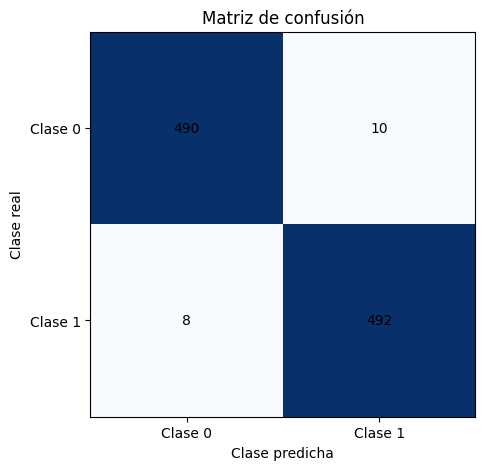

In [113]:
# Confusion matrix
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification report
cr = classification_report(y_test, y_pred)
print(cr)

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.xticks([0, 1], ["Clase 0", "Clase 1"])
plt.yticks([0, 1], ["Clase 0", "Clase 1"])

for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i][j], ha='center', va='center')

plt.show()

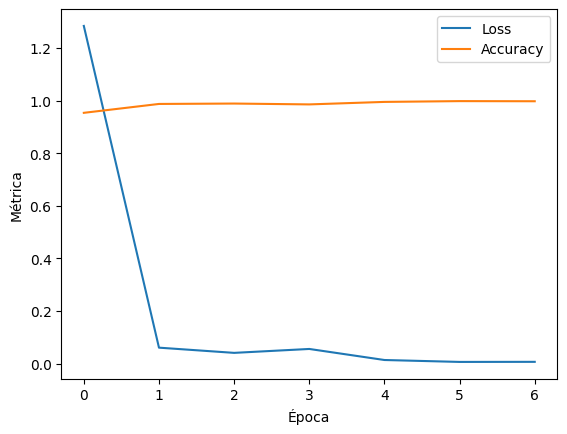

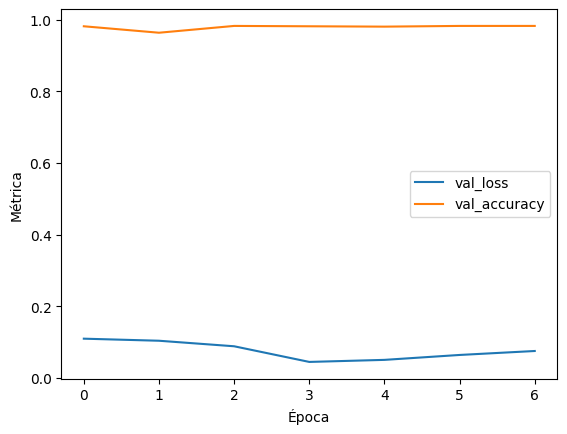

In [109]:
# Datos de entrenamiento
loss = history.history["loss"]
accuracy = history.history["accuracy"]

# Datos de validación
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

# Gráfico del loss y el accuracy
plt.plot(loss, label="Loss")
plt.plot(accuracy, label="Accuracy")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.legend()
plt.show()

# Gráfico del val_loss y el val_accuracy
plt.plot(val_loss, label="val_loss")
plt.plot(val_accuracy, label="val_accuracy")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.legend()
plt.show()